# Time Serie Analysis

Neste notebook iremos realizar análises nos dados considerando-os como séries temporais. O intuito aqui é avaliar as correlações para verificar se as séries possuem igualdades, i.e, 'caminham' junto ao longo do tempo de maneira similar.

## 1. Leitura dos dados

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from featureExtraction import featuresFromDataframe
from readAccelerometerData import createDatasetFromFiles
from sklearn.preprocessing import LabelEncoder

#Estilo ggplot
plt.style.use('ggplot')

In [2]:
'''Realiza a leitura dos dados em formato bruto'''
#type_data: Define se os dados são do acelerometro (0) ou giroscopio (1)
def read_data(type_data):
    
    #Setando diretorio Data como o atual
    os.chdir('../Data')

    #Criando dataframe com os dados
    dataf = createDatasetFromFiles()

    #Concatenando os resultados das colunas
    featMat = []
    for k in dataf:

        drug_order = int(dataf[k][1][1][2])
        featVec = [k, drug_order]

        for drug in [1,2]:
            for measure in [1,2,3,4,5,6,7,8]:
                featVec = featVec + list(dataf[k][drug][measure][type_data])

        featMat.append(featVec)

    #Transformando em dataframe
    featMat = pd.DataFrame(featMat)

    #GERANDO DATAFRAME
    start = 2
    end = 1818
    step = 1816 #Tamanho de cada serie temporal: 1816

    #Roda para os 16 arquivos
    df_final = pd.DataFrame()
    for i in range(16):
        df_final = df_final.append(pd.DataFrame(featMat.iloc[:,start:end].values))

        #Atualiza range para pegar outro arquivo
        start+=step
        end+=step

    #Inserindo novas colunas
    df_final.insert(loc=0,column='name',value=np.tile(featMat.iloc[:,0],16))
    df_final.insert(loc=1,column='measure',value=np.tile(np.repeat([1,2,3,4,5,6,7,8],22),2))
    df_final.insert(loc=1,column='evaluate',value=np.tile(featMat.iloc[:,1],16))
    df_final.insert(loc=df_final.shape[1],column='drug',value=np.repeat([1,2],176))

    #Sort
    df_final.sort_values(by=['name','drug','measure'],inplace=True)

    #Mapeando droga
    df_final.loc[:,'drug'] = df_final['drug'].map({1:'placebo',2:'CBD'})

    #Filtro para a avaliacao
    filter_evaluate = ((df_final['evaluate'] == 1) & (df_final['drug'] == 'placebo')) | ((df_final['evaluate'] == 2) & (df_final['drug'] == 'CBD'))

    #Mapeando medida
    df_final['measure'] = df_final['measure'].map({1:'B',3:'P',4:'A',5:'S1',6:'S2',7:'F1',8:'F2'})

    #Setando dados - Agora evaluate indica o numero da avalicao
    df_final.loc[filter_evaluate,'evaluate'] = 1
    df_final.loc[~filter_evaluate,'evaluate'] = 2

    #Filtrando - exclusao da medida 2 por nao ser relevante segundo os medicos
    df_final.dropna(inplace=True)
    
    #Criando encoder
    le = LabelEncoder().fit(df_final['name'])

    #Codificando nome
    df_final['name'] = ['person_' + str(ID) for ID in le.transform(df_final['name'])]

    #Nome como index
    df_final.set_index('name',inplace=True)

    #Transposta
    df_final = df_final.T

    #Renomeando colunas
    list_cols = []
    for index,col in enumerate(df_final.iloc[:2,:]):
        list_cols.append(col + '-' + str(df_final.iloc[1,index]) + '-' + str(df_final.iloc[-1,index]))
    df_final.columns = list_cols

    #Excluindo as duas primeiras linhas
    df_final = df_final.iloc[2:,:]

    #Excluindo ultima linhas
    df_final = df_final.iloc[:-1,:]

    #Transformando colunas para float
    return df_final.astype('float')

'''Plot de um heatmap.'''
def heatmap(df,title=''):

    # Criando figura
    fig,ax = plt.subplots(figsize=(15,9))
    
    # Coloca titulo
    ax.set_title(title)

    # Heatmap
    sns.heatmap(data=df,ax=ax)

    # Show data
    plt.show()

In [3]:
#Leitura dos dados
df_parkinson = read_data(0)

## 2. Análises

Nas análises seguintes iremos utilizar métodos automáticos para avaliar as correlações.

## 2.1 Correlação entre pessoas/fases iguais em diferentes drogas.

Dada uma pessoa e uma mesma fase iremos avaliar se suas séries são correlacionadas para drogas diferentes.

Por exemplo, verificaremos se person_0-faseB-placebo possui correlação com person_0-faseB-CBD.

In [4]:
#Pessoas unicas
unique_people = df_parkinson.columns.map(lambda x: x.split('-')[0]).unique().values

#Correlacao maiores que 0.4
for person in unique_people:
    for measure in ['B','P','A','S1','S2','F1','F2']:
        list_cols = []
        for drug in ['placebo','CBD']:
            list_cols.append(person + '-' + measure + '-' + drug)
        if(df_parkinson[list_cols].corr().abs().iloc[0,1] > 0.4):
            print(df_parkinson[list_cols].corr().abs().iloc[0,1])

Não foi constatado nenhuma grande correlação.

## 2.2 Correlação entre fases/drogas iguais mas pessoas diferentes

Dada a mesma fase com o mesmo tipo de droga, iremos avaliar as correlações para pessoas diferentes.

In [5]:
#Extraindo colunas
for measure in ['B','P','A','S1','S2','F1','F2']:
    for drug in ['placebo','CBD']:        
        cols = df_parkinson.columns.values
        cols = list(filter(lambda x: measure+'-'+drug in x,cols))
        
        #Correlacao
        for c1 in cols:
            for c2 in cols:
                if((df_parkinson.loc[:,[c1,c2]].corr().abs().iloc[0,1] > 0.4) & (c1 != c2)):
                    print(c1,c2)

person_5-B-placebo person_21-B-placebo
person_21-B-placebo person_5-B-placebo
person_10-A-CBD person_21-A-CBD
person_21-A-CBD person_10-A-CBD
person_4-S1-placebo person_8-S1-placebo
person_8-S1-placebo person_4-S1-placebo
person_10-F1-CBD person_21-F1-CBD
person_21-F1-CBD person_10-F1-CBD


Não há grandes correlações também (ocorre apenas 8 vezes).

## 2.3 Correlação das pessoas na mesma droga

Vamos verificar se as séries das pessoas no mesmo grupo de drogas são correlacionadas.

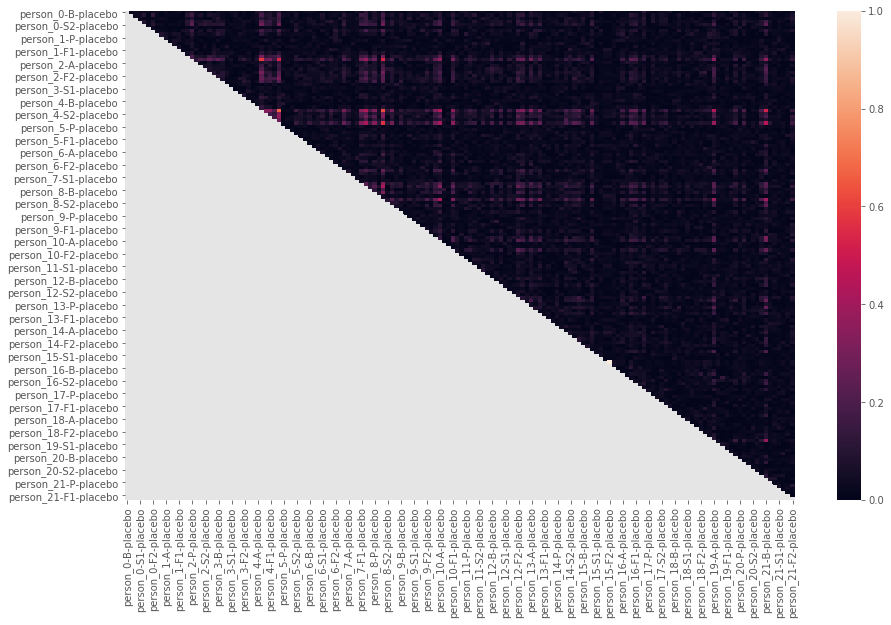

In [6]:
#Extraindo colunas
cols = df_parkinson.columns.values

#Filtrando por placebo
cols = list(filter(lambda x: 'placebo' in x,cols))

#Matrix de correlacao
corr_matrix = df_parkinson.loc[:,cols].corr().abs()
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Heatmap
heatmap(corr_matrix)

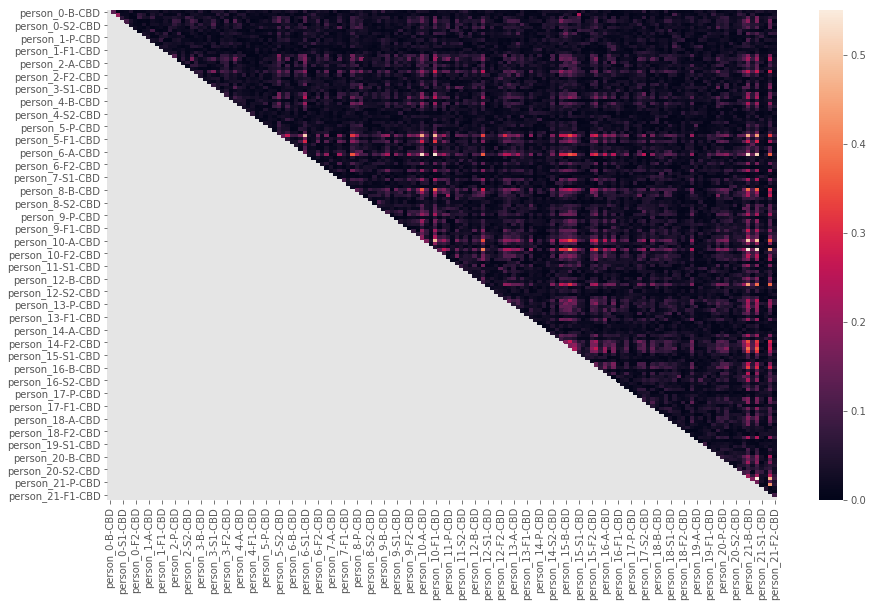

In [7]:
#Extraindo colunas
cols = df_parkinson.columns.values

#Filtrando por placebo
cols = list(filter(lambda x: 'CBD' in x,cols))

#Matrix de correlacao
corr_matrix = df_parkinson.loc[:,cols].corr().abs()
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Heatmap
heatmap(corr_matrix)

Pelo heatmap das correlações é possível verificar que existe (algumas) que são fortes. Contudo, não existe nenhum padrão entre eles.

## 3. Conclusão

A ideia das correlações entre as séries temporais 'brutas' dos dados era de encontrar algum padrão que nos ajuda-se a entender melhor como poderíamos classificar/agrupar os mesmos. Contudo, não foi possível obter nenhum insight interessante.

Assim, nossa suposição inicial de que por exemplo pessoas que usam a mesma droga possuem séries parecidas acabou sendo equivocada. Mesmo realizando outros tipos de análises com a correlação também não foi possível extrair informações úteis.

Portanto, concluímos que as correlações (independente da forma como você olha) está distribuída de maneira muito aleatória nos dados não sendo interessante para nós.

## 4. Observação

- É importante notar que testamos as correlações tanto para o acelerômetro como para o giroscópio.